# Summary analysis
Mouna Ammar & Paul Gazel

In this part we will analyse the summaries of the queries. Those are the documents generated after each query as explained in the report. As we have explained, once imported into SQL the summaries have the following format: A date followed by a list of one or several newspapers (maximum 3) and finally the number of articles those newspapers have published in the given day (With the keyword Covid). Those were generated simply because as the API only provides us a maximum of 100 articles per query we may end up losing some articles in the process.

In [10]:
import psycopg2
import sys
import os
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from datetime import datetime

The summary's files have been imported into an SQL dataset in the following table:

    CREATE TABLE SUMMARY (
    summary_id SERIAL PRIMARY KEY,
    "date" VARCHAR(10) NOT NULL,
    "papers" VARCHAR(100) NOT NULL,
    num_articles INTEGER)
    
We start by connecting to the SQL database and verifying that everything works correctly.

In [2]:
try:
    conn = psycopg2.connect("dbname='postgres' user='postgres' host='localhost' password='pass1234'")
    print('Success connecting to the database')
except:
    print('I am unable to connect to the database')
    sys.exit()

cursor = conn.cursor()

Success connecting to the database


In [3]:
cursor.execute("""SELECT * FROM summary""")
rows = cursor.fetchall()
print(rows[0:4])

[(1, '2021-12-08', 'abc-news_abc-news-au_aftenposten', 93), (2, '2021-12-08', 'al-jazeera-english_google-news-ar_argaam', 15), (3, '2021-12-08', 'ars-technica_ary-news_associated-press', 45), (4, '2021-12-08', 'australian-financial-review_axios_bbc-news', 62)]


Now that we have correctly connected to the database let's start by plotting the number of articles per day over the month of data we have.

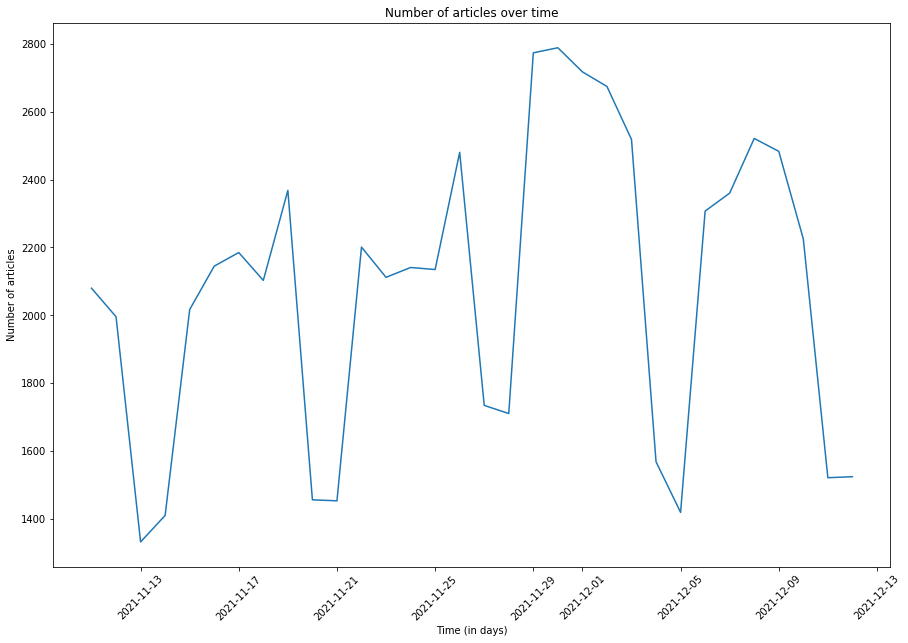

In [11]:
cursor.execute("""
SELECT SUM(num_articles), date FROM SUMMARY
GROUP BY date
ORDER BY date
""")
rows = cursor.fetchall()

# Plot number of articles per day
# Separate X and Y
x = []
y = []
for num_articles, date in rows:
    x.append(datetime.strptime(date, '%Y-%m-%d'))
    y.append(num_articles)

    
plt.plot(x, y)
plt.title("Number of articles over time")
plt.xlabel('Time (in days)')
plt.ylabel('Number of articles')
plt.xticks(rotation = 45)
plt.show()

Looking at this first plot, we can see that there is a pattern on the number of published papers per day. This is explained by the fact that in the weekends the number of published articles drops considerably. We can also see an overall increase starting on the 26th of November which matches with the announcement of the new variant Omicron by the WHO.

As explained earlier, each row of summary represent one or several papers which makes the analysis based on category, language or country from the sources imposible. Those kind of analysis will have to be done on the articles.

Now we have setted those summaries because some articles are lost in the querying process. We will now see how many article we lose and from which newspapers.

In [5]:
cursor.execute("""
SELECT SUM(num_articles), COUNT(*) FROM 
( SELECT num_articles FROM summary WHERE num_articles > 100
) AS rows_over
""")
rows_lost = cursor.fetchall()

# Articles are only lost when the query returns more than 100 articles. However not all articles are lost,
# only the ones above 100.
articles_lost = rows_lost[0][0] - 100 * rows_lost[0][1]

cursor.execute("""
SELECT SUM(num_articles) FROM summary
""")
rows_all = cursor.fetchall()
print('Number of articles lost in the process: ', articles_lost, ' over ', rows_all[0][0])
print('Number of articles that we have: ', rows_all[0][0] - articles_lost)

Number of articles lost in the process:  20340  over  66466
Number of articles that we have:  46126


Over the 66 466 articles returned from the queries, the restriction of being able to save only 100 articles per query end up costing us 20 340 articles and leaving us with 46 126 articles. The final number of articles we have is decent in order to make an analysis on them, however the number of articles lost in the process seems quite elevated. 

Let's now look into more details which articles do we lose in the process, meaning how are they distributed among the newspapers.

In [6]:
cursor.execute("""
SELECT SUM(num_articles), papers, COUNT(*) FROM 
( SELECT num_articles, papers FROM summary WHERE num_articles > 100
) AS rows_over
GROUP BY papers
ORDER BY SUM(num_articles)
""")
rows = cursor.fetchall()

results = []

all_articles_lost = sum([x[0] - 100 * x[2] for x in rows])

for num_articles, papers, times_lost in rows:
    articles_lost = num_articles - 100 * times_lost
    percentage_lost = (articles_lost / all_articles_lost) * 100
    row = (papers, times_lost, articles_lost, percentage_lost)
    
    results.append(row)
    
df = pd.DataFrame(results, columns=['Newspapers', 'Times articles are lost','Number of articles lost', 'Percentage of articles lost'])
df = df.sort_values(by=['Number of articles lost'],ascending=False)
df

,Newspapers,Times articles are lost,Number of articles lost,Percentage of articles lost
6,la-nacion,32,17893,87.969518
4,recode_reddit-r-all_reuters,19,752,3.697148
5,la-repubblica_le-monde_lenta,23,605,2.974435
1,independent,11,430,2.114061
3,google-news-is_the-times-of-india_google-news-ru,15,425,2.089479
2,ansa_google-news-au_google-news-br,16,227,1.116028
0,bleacher-report_bloomberg_breitbart-news,2,8,0.039331


In this table we can see that from the 20 340 articles lost in the querying process, 88% of them comes from a single newspaper: La Nacion.

This means that without la nacion only 1 847 articles are lost in the process which end up being pretty small compared to the final number of articles we have.

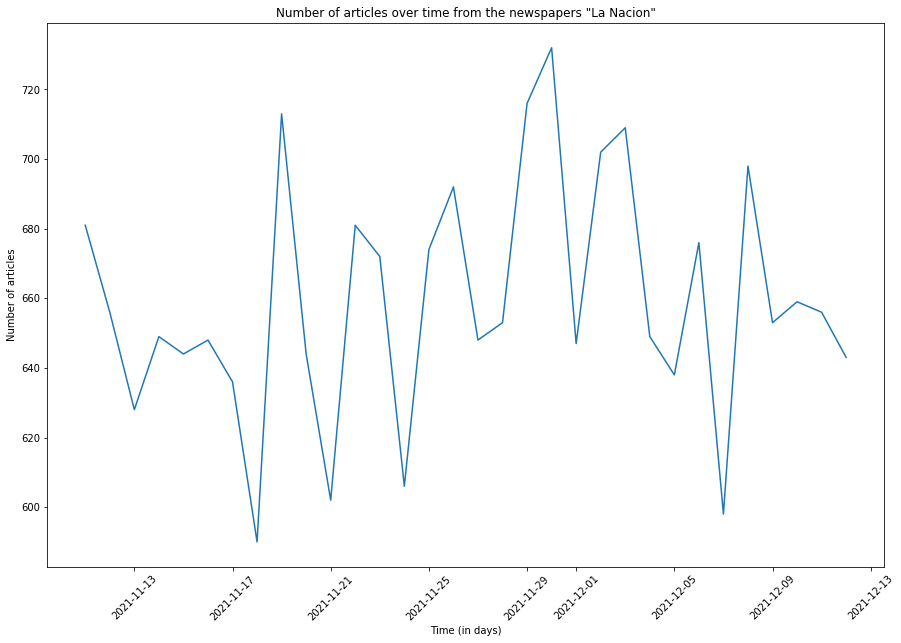

In [12]:
cursor.execute("""
SELECT SUM(num_articles), date FROM SUMMARY
WHERE papers = 'la-nacion'
GROUP BY date
ORDER BY date
""")
rows = cursor.fetchall()

# Plot number of articles per day
# Separate X and Y
x = []
y = []
for num_articles, date in rows:
    x.append(datetime.strptime(date, '%Y-%m-%d'))
    y.append(num_articles)

    
plt.plot(x, y)
plt.title("Number of articles over time from the newspapers \"La Nacion\"")
plt.xlabel('Time (in days)')
plt.ylabel('Number of articles')
plt.xticks(rotation = 45)
plt.show()

In [8]:
average_daily_articles = sum(y) / len(y)
print('Average number of articles per day from "La Nacion": ', average_daily_articles)

Average number of articles per day from "La Nacion":  659.15625


From the last plot and the previous cell we can see that the newspaper "La Nacion" publish an insane amount of papers per day, with an average of 659. Far from what the API query allows us to collect. We ended up deciding leaving out the majority of them and only saving 100 per day from this newspaper. However, due to how the querying is done, the articles are ordered by "popularity" meaning that articles from popular sources and publishers come first, we do collect the "best" articles and leave out the less relevant ones.

To conclude the part about the articles we lose during the querying process, it ends up being less serious than expected due to the fact that the majority of lost items comes from a single source and this loss is spreaded aproximately equitably within the whole month of data.

In the end we end up with the following distribution of articles over time, which is almost identical to the ones with the losing articles.

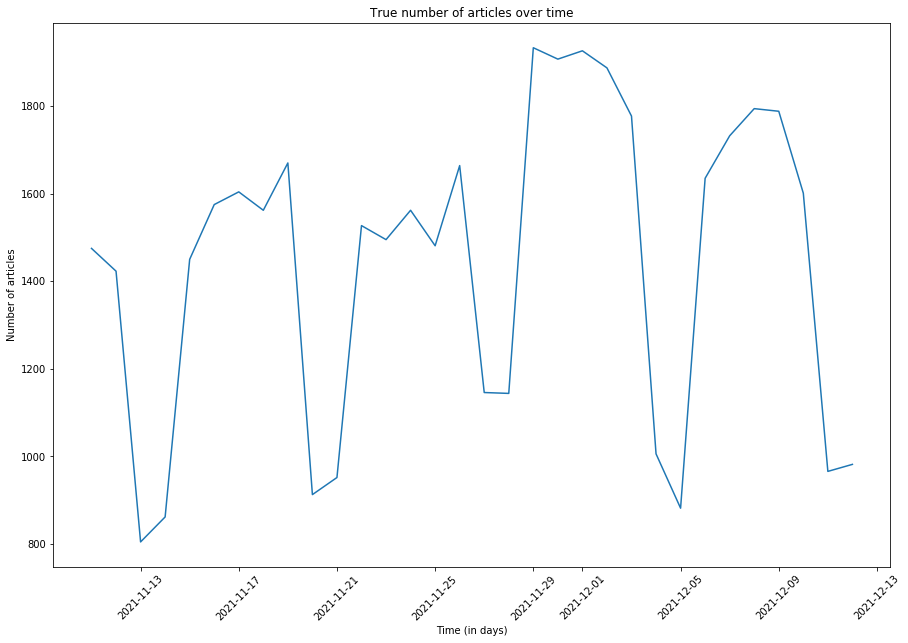

In [13]:
cursor.execute("""
SELECT SUM(num_articles), date, COUNT(*) FROM 
( SELECT num_articles, date FROM summary WHERE num_articles > 100
) AS rows_over
GROUP BY date
ORDER BY date
""")
rows_over = cursor.fetchall()

cursor.execute("""
SELECT SUM(num_articles), date FROM 
( SELECT num_articles, date FROM summary WHERE num_articles <= 100
) AS rows_not_over
GROUP BY date
ORDER BY date
""")
rows_non_over = cursor.fetchall()

# Plot number of articles per day
# Separate X and Y
x = []
y = []



for data_over, data_non_over in zip(rows_over, rows_non_over):
    aux = data_non_over[0] + 100 * data_over[2]
    
    x.append(datetime.strptime(data_over[1], '%Y-%m-%d'))
    y.append(aux)
    

    
plt.plot(x, y)
plt.title("True number of articles over time")
plt.xlabel('Time (in days)')
plt.ylabel('Number of articles')
plt.xticks(rotation = 45)
plt.show()